In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from datetime import timedelta   
import ffmpeg
from matplotlib import animation
from src.plot_utils import draw_pitch
from IPython.display import HTML
import matplotlib as mpl
from celluloid import Camera
import datetime

mpl.rcParams['animation.embed_limit'] = 100

### 데이터 불러오기

In [5]:
df = pd.read_json("./Data/sample_match_1.json")

### 한 시점의 Voronoi Diagram 그리기

In [6]:
def snap_shot(frame, figx = None):

    location = df[df['Frame'] == frame].iloc[:,3:].drop(['Ball_x', 'Ball_y'], axis=1).dropna(axis=1).iloc[0,:]
    points = [[location[2*i], location[2*i+1]] for i in range(len(location)//2)]
    players = [location.index[2*i].split('_')[0] for i in range(len(points))]
    n_points = np.vstack([points,
                        [[-p[0], p[1]]for p in points],
                        [[p[0], -p[1]]for p in points],
                        [[-p[0] +208, p[1]]for p in points],
                        [[p[0], -p[1]+136]for p in points]])
    n_vor = Voronoi(n_points)

    ii = 0
    
    figobj = []
    if figx == None:
        fig, ax = draw_pitch('white', 'black', size_x=18, size_y=12)
    else :
        fig, ax = figx    
    
    ball_x, ball_y = df.loc[df['Frame'] == frame, ['Ball_x', 'Ball_y']].values[0]
    
    sec = float(df[df['Frame'] == frame]['Time [s]'].values[0])
    t_time = str(int(sec//60)) + ':' + str(round(sec%60, 2)) 
    figobj.append(ax.text(48, 70, t_time, fontsize=20))
    
    for t, p in zip(players, points):
        if 'H' in t:
            color = 'red'
        else:
            color = 'blue'
        
        obj = ax.scatter(p[0], p[1], c=color, s=80)
        figobj.append(obj)
        figobj.append(ax.text(p[0], p[1], s=t, fontsize=20, color=color))
        
        
        if not -1 in n_vor.regions[n_vor.point_region[ii]]:
            polygon = [n_vor.vertices[i] for i in n_vor.regions[n_vor.point_region[ii]]]
            if len(polygon) > 0:        
                polygon.append(polygon[0])
                xs, ys = zip(*polygon)
                obj = ax.plot(xs, ys, c=color) 
                figobj.append(obj)
                obj = ax.fill(xs, ys, c=color, alpha=0.3)
                figobj.append(obj)
        ii+=1

    obj = ax.scatter(ball_x, ball_y, c='black', s=100, marker='h')
    figobj.append(obj)
                                  
    return fig, ax, figobj

                    

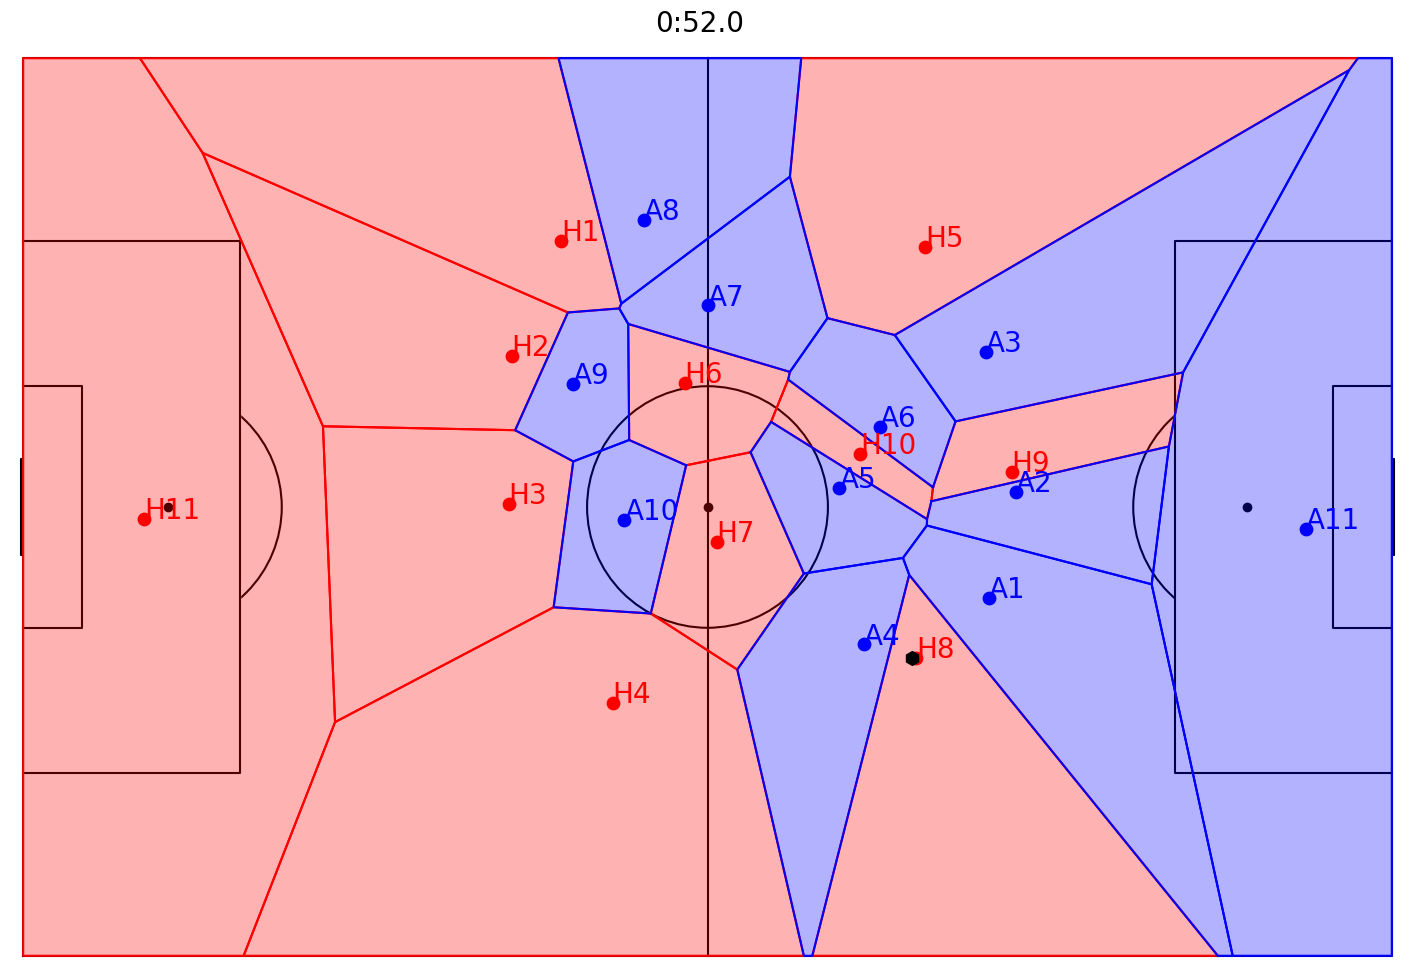

In [7]:
frame = 100
fig, ax, figobjs = snap_shot(1300)
plt.show()

### 연속적인 Voronoi Diagram 그리기

In [8]:
def save_clip(
    start_frame, end_frame, fname='test', fps=25, figax=None
):
    writer = animation.FFMpegWriter(fps=fps)

    if figax is None:
        fig, ax = draw_pitch(pitch='white', line='black')
    else:
        fig, ax = figax

    fig.set_tight_layout(True)

    with writer.saving(fig, fname, dpi=50):
        for frame in np.arange(start_frame, end_frame, 2):
            fig, ax, figobjs = snap_shot(frame, figx = (fig, ax))
        
            writer.grab_frame()
            for obj in figobjs:
                if type(obj) == list:
                    obj[0].remove()
                else:
                    obj.remove()

    plt.clf()
    plt.close(fig)

In [134]:
save_clip(600, 1500, fname='./Clips/Game1_600_1500.mp4')